In [1]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import book_plots
from filterpy.discrete_bayes import normalize
from filterpy.discrete_bayes import update
from filterpy.discrete_bayes import predict

### Tracking a Dog

Let's represent our belief of Simon's position in a NumPy array. 

In [2]:
belief = np.array([1./10]*10)
print(belief)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In Bayesian statistics this is called a **prior**. It is the probability prior to incorporating measurements or other information.                             
More completely, this is called the prior probability distribution. A probability distribution is a collection of all possible probabilities for an event. Probability distributions always sum to 1 because something had to happen; the distribution lists all possible events and the probability of each.      
Bayesian statistics takes past information (the prior) into account. 

Now let's create a map of the hallway. We'll place the first two doors close together, and then another door further away. We will use 1 for doors, and 0 for walls:

In [3]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

I start listening to Simon's transmissions on the network, and the first data I get from the sensor is door. For the moment assume the sensor always returns the correct answer. From this I conclude that he is in front of a door, but which one? I have no reason to believe he is in front of the first, second, or third door. What I can do is assign a probability to each door. All doors are equally likely, and there are three of them, so I assign a probability of 1/3 to each door.

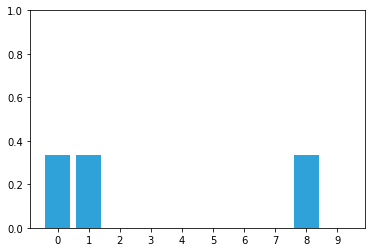

In [4]:
belief = np.array([1./3, 1./3, 0, 0, 0, 0, 0, 0, 1/3, 0])
book_plots.bar_plot(belief)

This distribution is called a categorical distribution, which is a discrete distribution describing the probability of observing $n$ outcomes. It is a multimodal distribution because we have multiple beliefs about the position of our dog.

### Extracting Information from Sensor Readings

Suppose we were to read the following from Simon's sensor:
* door
* move right
* door
Can we deduce Simon's location? Of course! Given the hallway's layout there is only one place from which you can get this sequence, and that is at the left end. Therefore we can confidently state that Simon is in front of the second doorway. If this is not clear, suppose Simon had started at the second or third door. After moving to the right, his sensor would have returned 'wall'. That doesn't match the sensor readings, so we know he didn't start there. We can continue with that logic for all the remaining starting positions. The only possibility is that he is now in front of the second door. Our belief is:

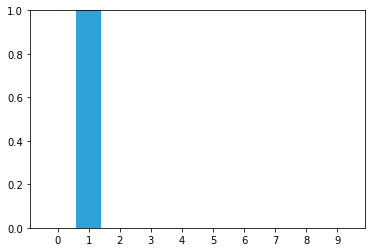

In [5]:
belief = np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
book_plots.bar_plot(belief)

### Noisy Sensors

Perfect sensors are rare. Perhaps the sensor would not detect a door if Simon sat in front of it while scratching himself, or misread if he is not facing down the hallway. Thus when I get door I cannot use 1/3 as the probability. I have to assign less than 1/3 to each door, and assign a small probability to each blank wall position. Something like       
```[.31, .31, .01, .01, .01, .01, .01, .01, .31, .01]```                     
The key, as with the problem above, is **probabilities**.        
We are already comfortable with assigning a probabilistic belief about the location of the dog; now we just have to incorporate
the additional uncertainty caused by the sensor noise.        
Say we think there is a 50% chance that our dog is in front of a specific door and we get a reading of 'door'. Well, we think
that is only likely to be true 0.6 of the time, so we multiply: 0.5 $\times$ 0.6 = 0.3.       
Likewise, if we think the chances that our dog is in front of a wall is 0.1, and the reading is 'door', we would multiply the probability by the chances of a miss: 0.1 $\times$ 0.2 = 0.02.                 

Say we get a reading of door, and suppose that testing shows that the sensor is 3 times more likely to be right than wrong. We should scale the probability distribution by 3 where there is a door.

In [6]:
def update_belief(hall, belief, z, correct_scale):
    for i, val in enumerate(hall):
        if val == z:
            belief[i] *= correct_scale

belief: [0.3 0.3 0.1 0.1 0.1 0.1 0.1 0.1 0.3 0.1]
sum = 1.6000000000000003


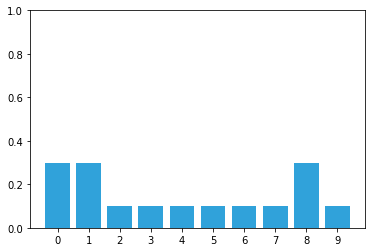

In [7]:
belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
update_belief(hallway, belief, z=reading, correct_scale=3.)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

This is not a probability distribution because it does not sum to 1.0. But the code is doing mostly the right thing - the doors are assigned a number (0.3) that is 3 times higher than the walls (0.1). All we need to do is normalize the result so that the probabilities correctly sum to 1.0. Normalization is done by dividing each element by the sum of all elements in the list.

Here is our improved version:

In [8]:
def scaled_update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)

In [9]:
belief = belief / sum(belief)
belief

array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625])

belief: [0.1875 0.1875 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.1875 0.0625]
sum = 1.0
probability of door = 0.1875
probability of wall = 0.06249999999999999


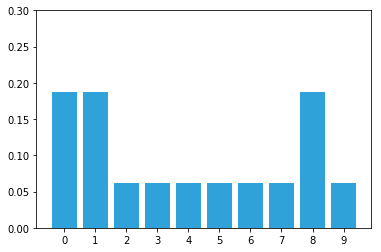

In [10]:
belief = np.array([0.1] * 10)
scaled_update(hallway, belief, z=1, z_prob=.75)

print('belief:', belief)
print('sum =', sum(belief))
print('probability of door =', belief[0])
print('probability of wall =', belief[2])
book_plots.bar_plot(belief, ylim=(0, .3))

This result is called the **posterior**, which is short for posterior probability distribution. All this means is a probability distribution after incorporating the measurement information (posterior means 'after' in this context). To review, the prior is the probability distribution before including the measurement's information.

Another term is the **likelihood**. When we computed ```belief[hall==z] *= scale``` we were computing how likely each position was given the measurement. The likelihood is not a probability distribution because it does not sum to one.

The combination of these gives the equation

$$\mathtt{posterior} = \frac{\mathtt{likelihood} \times \mathtt{prior}}{\mathtt{normalization}}$$

### Incorporating Movement

First let's deal with the simple case - assume the movement sensor is perfect, and it reports that the dog has moved one space to the right. How would we alter our ```belief``` array?                               

In [11]:
def perfect_predict(belief, move):
    """ move the position by `move` spaces, where positive is 
    to the right, and negative is to the left
    """
    n = len(belief)
    result = np.zeros(n)
    for i in range(n):
        result[i] = belief[(i-move) % n]
    return result

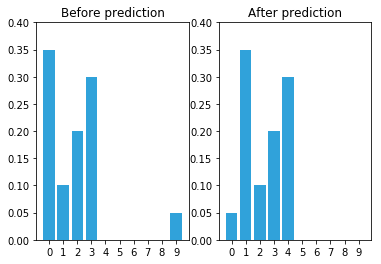

In [12]:
belief = np.array([.35, .1, .2, .3, 0, 0, 0, 0, 0, .05])
plt.subplot(121)
book_plots.bar_plot(belief, title='Before prediction', ylim=(0, .4))

belief = perfect_predict(belief, 1)
plt.subplot(122)
book_plots.bar_plot(belief, title='After prediction', ylim=(0, .4))

We can see that we correctly shifted all values one position to the right, wrapping from the end of the array back to the beginning.

### Adding Uncertainty to the Prediction

Assume that the sensor's movement measurement is 80% likely to be correct, 10% likely to overshoot one position to the right, and 10% likely to undershoot to the left. That is, if the movement measurement is 4 (meaning 4 spaces to the right), the dog is 80% likely to have moved 4 spaces to the right, 10% to have moved 3 spaces, and 10% to have moved 5 spaces.

Each result in the array now needs to incorporate probabilities for 3 different situations. For example, consider the reported movement of 2. If we are 100% certain the dog started from position 3, then there is an 80% chance he is at 5, and a 10% chance for either 4 or 6. Let's try coding that:

In [13]:
def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

array([0. , 0. , 0. , 0. , 0.1, 0.8, 0.1, 0. , 0. , 0. ])

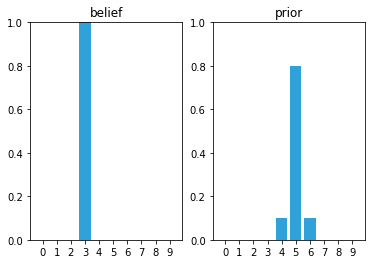

In [14]:
belief = [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

Now what happens when our belief is not 100% certain?

array([0.  , 0.  , 0.  , 0.04, 0.38, 0.52, 0.06, 0.  , 0.  , 0.  ])

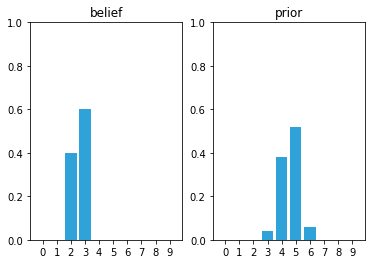

In [15]:
belief = [0, 0, .4, .6, 0, 0, 0, 0, 0, 0]
prior = predict_move(belief, 2, .1, .8, .1)
book_plots.plot_belief_vs_prior(belief, prior)
prior

If you look at the probabilities after performing the update you might be dismayed. In the example above we started with probabilities of 0.4 and 0.6 in two positions; after performing the update the probabilities are not only lowered, but they are strewn out across the map.

This is not a coincidence, or the result of a carefully chosen example - it is always true of the prediction. **If the sensor is noisy we lose some information on every prediction.** Suppose we were to perform the prediction an infinite number of times - what would the result be? If we lose information on every step, we must eventually end up with no information at all, and our probabilities will be equally distributed across the belief array. Let's try this with 100 iterations. 

![text](animations/02_no_info.gif)     

After 100 iterations we have lost all information, even though we were 100% sure that we
started in position 1.

### Integrating Measurements and Movement Updates

The problem of loosing information during an update may make it seem as if our system
would quickly devolve into no knowledge. However, recall that our process is not an endless
series of updates, but of measure->update->measure->update->measure->update. . . The
output of the measure step is fed into the update. The update step, with a degraded
certainty, is then fed into the measure step.

Let's think about this intuitively. Consider a simple case - you are tracking a dog while he sits still. During each prediction you predict he doesn't move. Your filter quickly converges on an accurate estimate of his position. Then the microwave in the kitchen turns on, and he goes streaking off. You don't know this, so at the next prediction you predict he is in the same spot. But the measurements tell a different story. As you incorporate the measurements your belief will be smeared along the hallway, leading towards the kitchen. On every epoch (cycle) your belief that he is sitting still will get smaller, and your belief that he is inbound towards the kitchen at a startling rate of speed increases.

In [16]:
def lh_hallway(hall, z, z_prob):
    """ compute likelihood that a measurement matches
    positions in the hallway."""
    
    try:
        scale = z_prob / (1. - z_prob)
    except ZeroDivisionError:
        scale = 1e8

    likelihood = np.ones(len(hall))
    likelihood[hall==z] *= scale
    return likelihood

##### Iteration 1.

likelihood:  [3. 3. 1. 1. 1. 1. 1. 1. 3. 1.]


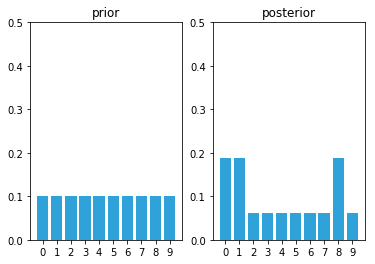

In [17]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
prior = np.array([.1] * 10)
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

print("likelihood: ",likelihood)

After the first update we have assigned a high probability to each door position, and a low probability to each wall position.

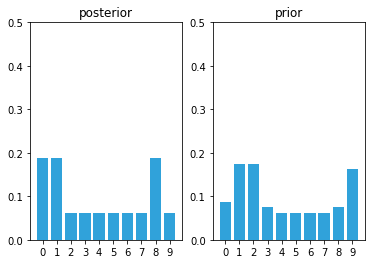

In [18]:
kernel = (.1, .8, .1)
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

##### Iteration 2.

likelihood:  [3. 3. 1. 1. 1. 1. 1. 1. 3. 1.]


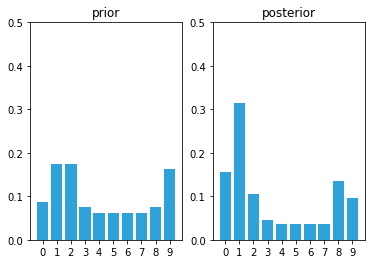

In [19]:
likelihood = lh_hallway(hallway, z=1, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

print("likelihood: ",likelihood)

Notice the tall bar at position 1. This corresponds with the (correct) case of starting at position 0, sensing a door, shifting 1 to the right, and sensing another door. No other positions make this set of observations as likely. Now we will add an update and then sense the wall.

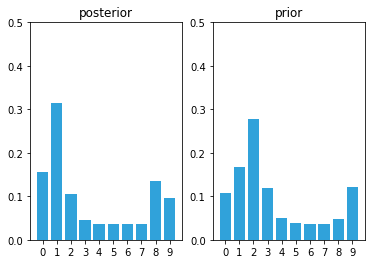

In [20]:
prior = predict(posterior, 1, kernel)
book_plots.plot_prior_vs_posterior(prior, posterior, True, ylim=(0,.5))

#### Iteration 3.

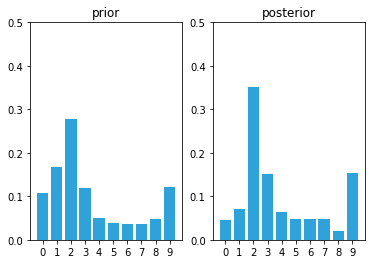

In [21]:
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))

This is exciting! We have a very prominent bar at position 2 with a value of around 35%. It is over twice the value of any other bar in the plot, and is about 4% larger than our last plot, where the tallest bar was around 31%. Let's see one more cycle.

#### Iteration 4.

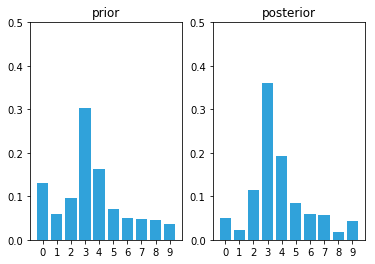

In [22]:
prior = predict(posterior, 1, kernel)
likelihood = lh_hallway(hallway, z=0, z_prob=.75)
posterior = update(likelihood, prior)
book_plots.plot_prior_vs_posterior(prior, posterior, ylim=(0,.5))